In [61]:


import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import time
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt

In [62]:


train_df = pd.read_csv("datasets/train.csv")
test_df = pd.read_csv("datasets/test.csv")

train_df.head()

,Unnamed: 0,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,fm,Fm_2,EVENT
0,0,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1677.0,695.0,0
1,1,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1561.0,696.0,0
2,2,6.5,0.17,8.35,749.0,211.0,0.011,0.117,1581.0,696.0,0
3,3,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1579.0,693.0,0
4,4,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1567.0,689.0,0


In [63]:


train_df.drop(columns=['Unnamed: 0'],inplace=True)

In [64]:


test_df.drop(columns=['Unnamed: 0'], inplace=True)

In [65]:


print(test_df.columns.tolist())

['Tp', 'Cl', 'pH', 'Redox', 'Leit', 'Trueb', 'Cl_2', 'fm', 'Fm_2', 'EVENT']


In [66]:


print(train_df.columns.tolist())

['Tp', 'Cl', 'pH', 'Redox', 'Leit', 'Trueb', 'Cl_2', 'fm', 'Fm_2', 'EVENT']


In [67]:


train_df.columns = train_df.columns.str.lower()

In [68]:


test_df.columns = test_df.columns.str.lower()

In [69]:


X_train = train_df.drop('event', axis=1)
y_train = train_df['event']

X_test = test_df.drop('event', axis=1)
y_test = test_df['event']


# ## Standardize the feature inputs

In [70]:


start_time = time.time()

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

end_time = time.time()
training_time= end_time-start_time

print(f"✅ Model training complete in {training_time:.4f} seconds")

✅ Model training complete in 3.6964 seconds


In [71]:


start_time = time.time()
y_pred = model.predict(X_test)
end_time = time.time()
inference_time= end_time-start_time

print("\n🧾 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print(f"Prediction complete in {inference_time:.4f} seconds")


🧾 Confusion Matrix:
[[115520  21717]
 [  1458    871]]

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91    137237
           1       0.04      0.37      0.07      2329

    accuracy                           0.83    139566
   macro avg       0.51      0.61      0.49    139566
weighted avg       0.97      0.83      0.89    139566

Prediction complete in 0.0285 seconds


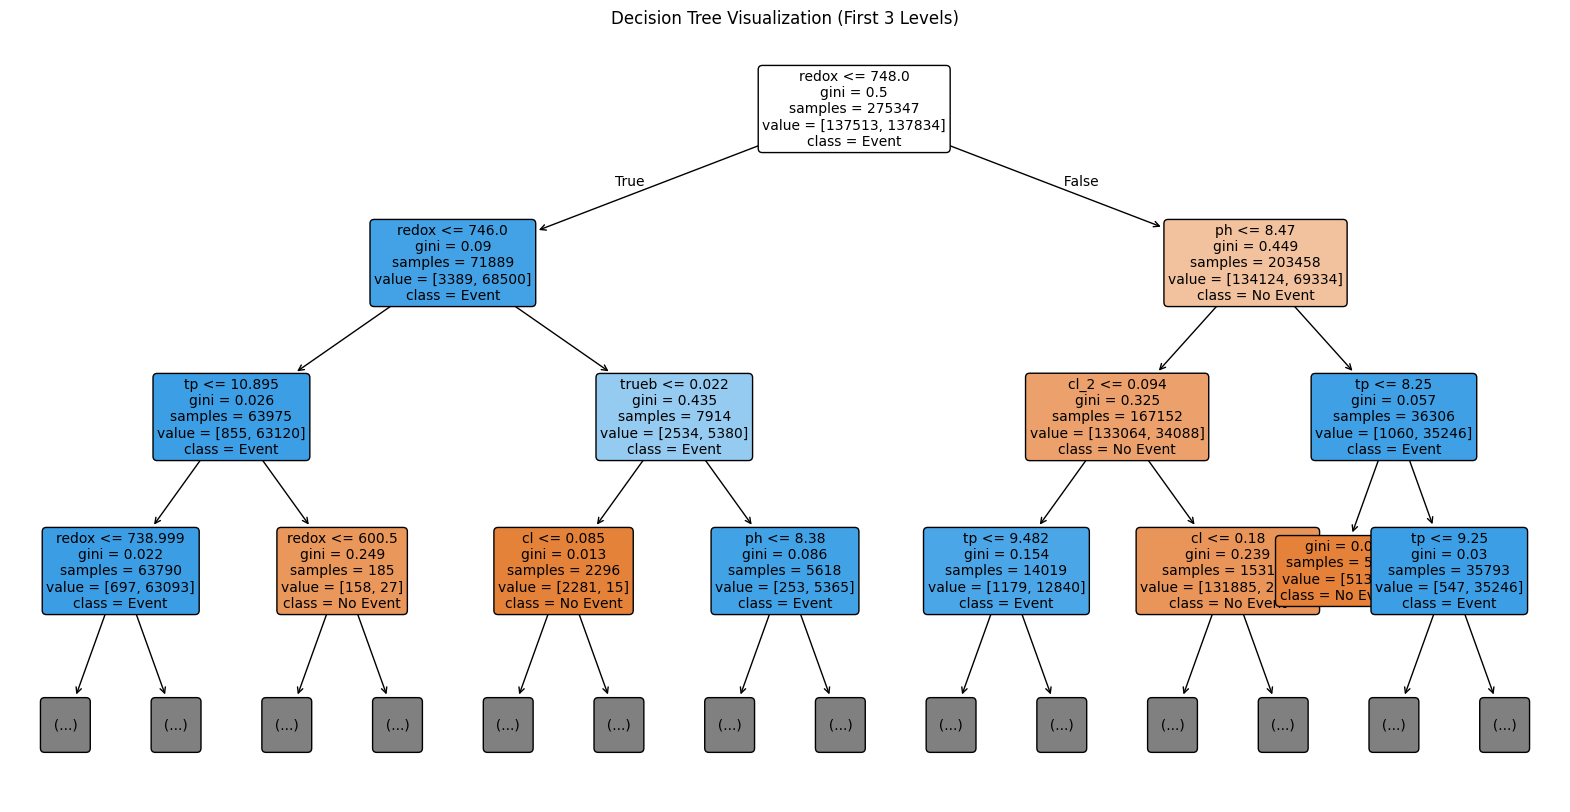

In [72]:


from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Set the figure size for better readability
plt.figure(figsize=(20, 10))

# Plot the tree
plot_tree(
    model,                      # your trained DecisionTreeClassifier
    feature_names=X_train.columns,  # use actual column names
    class_names=['No Event', 'Event'],  # labels for target classes
    filled=True,                # color nodes by class
    rounded=True,               # rounded boxes
    max_depth=3,                # limit the depth to avoid clutter (adjust as needed)
    fontsize=10
)

plt.title("Decision Tree Visualization (First 3 Levels)")
plt.show()

In [73]:


from sklearn.tree import export_graphviz
import graphviz

# Export the decision tree as a DOT format string
dot_data = export_graphviz(
    model,
    out_file=None,
    feature_names=X_train.columns,
    class_names=['No Event', 'Event'],
    filled=True,
    rounded=True,
    special_characters=True
)

In [ ]:


from bayes_opt import BayesianOptimization
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
import numpy as np

# Objective function to maximize (higher F1 score = better model)
def optimize_decision_tree(max_depth, min_samples_split, min_samples_leaf):
    model = DecisionTreeClassifier(
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42
    )
    # Use cross-validation score (f1 macro for imbalanced data)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1_macro')
    return np.mean(scores)

# Define the hyperparameter search space
param_bounds = {
    'max_depth': (3, 20),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10)
}

# Initialize the Bayesian optimizer
optimizer = BayesianOptimization(
    f=optimize_decision_tree,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)

# Start optimization
optimizer.maximize(init_points=5, n_iter=20)

# Best parameters found
print("\nBest parameters found:")
print(optimizer.max)

# Store best parameters found by BayesianOptimization
best_params = optimizer.max['params']

|   iter    |  target   | max_depth | min_sa... | min_sa... |
-------------------------------------------------------------
| 1         | 0.7829    | 9.367     | 9.556     | 15.18     |
| 2         | 0.8182    | 13.18     | 2.404     | 4.808     |
| 3         | 0.8867    | 3.987     | 8.796     | 12.82     |
| 4         | 0.8281    | 15.04     | 1.185     | 19.46     |
| 5         | 0.8184    | 17.15     | 2.911     | 5.273     |
| 6         | 0.8867    | 3.931     | 7.984     | 13.05     |
| 7         | 0.8867    | 3.0       | 7.601     | 9.519     |
| 8         | 0.8867    | 3.0       | 1.0       | 11.07     |
| 9         | 0.8867    | 3.0       | 1.0       | 18.49     |
| 10        | 0.8867    | 3.0       | 1.0       | 2.0       |
| 11        | 0.8867    | 3.0       | 10.0      | 2.0       |
| 12        | 0.8867    | 3.076     | 7.916     | 19.81     |
| 13        | 0.8739    | 8.952     | 10.0      | 2.0       |
| 14        | 0.7984    | 20.0      | 10.0      | 2.0       |
| 15    

In [ ]:


# Extract and convert best parameters
raw_best_params = optimizer.max['params']
best_params = {
    'max_depth': int(raw_best_params['max_depth']),
    'min_samples_split': int(raw_best_params['min_samples_split']),
    'min_samples_leaf': int(raw_best_params['min_samples_leaf'])
}

# Train the best model using found parameters
from sklearn.tree import DecisionTreeClassifier
import time

start_time = time.time()

best_model = DecisionTreeClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time

print(f"✅ Training complete in {training_time:.4f} seconds")

In [ ]:


# Evaluate
start_time = time.time()

y_pred = best_model.predict(X_test)

end_time = time.time()
Inference_time= end_time-start_time

print(f"Prediction complete in {inference_time:.4f} seconds")

In [ ]:


print(classification_report(y_test, y_pred,output_dict=True))

In [ ]:


print("\n🧾 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

In [ ]:


print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:


y_pred = best_model.predict(X_test)

print("\n🧾 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

In [ ]:


shap_values = shap.TreeExplainer(best_model).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [ ]:


import lime
import lime.lime_tabular
import numpy as np

# Create the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),        # Your training features
    feature_names=X_train.columns,          # Column names
    class_names=['No Event', 'Event'],      # Target class names
    mode='classification'                   # Since you're predicting classes
)

# Choose an instance from the test set to explain
i = 10  # You can change this index to any row in your test set
exp = explainer.explain_instance(
    data_row=X_test.iloc[i],
    predict_fn=model.predict_proba
)

# Show explanation in notebook
exp.show_in_notebook(show_table=True)